In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd

# Set the Google Cloud project ID
project_id = "sublime-shift-464703-a2"
client = bigquery.Client(project=project_id)

# SQL query to load the BigQuery table
query = """
SELECT *
FROM `sublime-shift-464703-a2.funnel_output.funnel_output_quantity`
"""

# Run the query and convert the result to a DataFrame
df = client.query(query).to_dataframe()

# Group by product category and calculate the average conversion label
conversion_by_category = (
    df.groupby("product_category_cleaned")["label"]
    .mean()
    .reset_index()
    .rename(columns={"label": "conversion_rate"})
    .sort_values(by="conversion_rate", ascending=False)
)

# Display the top categories by conversion rate
print(conversion_by_category.head())

                  product_category_cleaned  conversion_rate
147  Safety Lens, Glasses Cleaners & Wipes         0.085607
129                           Other Safety         0.056674
82                      Hearing Protection         0.046801
90                  Honeywell Best Sellers         0.044818
63                             Finger Cots         0.041009


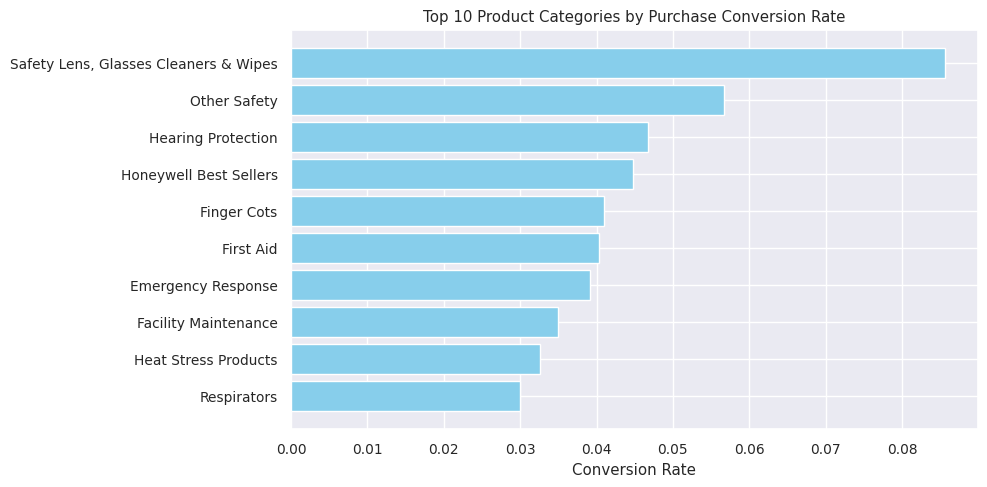

In [ ]:
# Top 10 product categories by conversion rate (for a clearer chart)
top_categories = conversion_by_category.head(10)

plt.figure(figsize=(10, 5))
plt.barh(top_categories["product_category_cleaned"], top_categories["conversion_rate"], color='skyblue')
plt.xlabel("Conversion Rate")
plt.title("Top 10 Product Categories by Purchase Conversion Rate")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Group by price range and calculate conversion rate
conversion_by_price_band = (
    df.groupby("price_band")["label"]
    .mean()
    .reset_index()
    .rename(columns={"label": "conversion_rate"})
    .sort_values(by="conversion_rate", ascending=False)
)

print(conversion_by_price_band)

  price_band  conversion_rate
1        Low         0.018958
0       High         0.009042
2        Mid         0.007918
3    Premium         0.003867
4    Unknown         0.000179


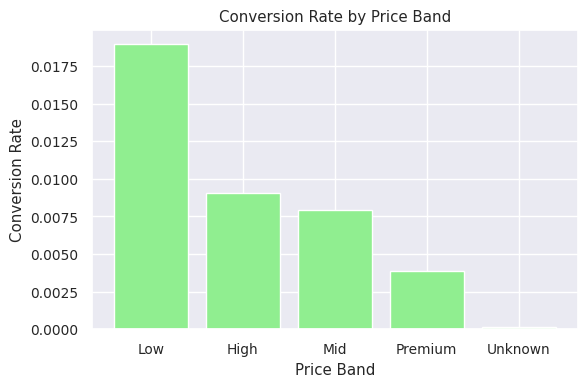

In [ ]:
# Price range conversion rate histogram
plt.figure(figsize=(6, 4))
plt.bar(conversion_by_price_band["price_band"], conversion_by_price_band["conversion_rate"], color='lightgreen')
plt.xlabel("Price Band")
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate by Price Band")
plt.tight_layout()
plt.show()

## Funnel Friction Heatmap by Product Type

In [ ]:
# Whether each user, each product category, and each stage has appeared
user_stage = df.groupby(['user_pseudo_id', 'product_category_cleaned', 'funnel_stage'])['event_timestamp'].min().reset_index()

# Create a column to indicate whether the stage has occurred (using pivot is more convenient for path analysis)
user_stage_pivot = user_stage.pivot_table(
    index=['user_pseudo_id', 'product_category_cleaned'],
    columns='funnel_stage',
    values='event_timestamp',
    aggfunc='count',
    fill_value=0
).reset_index()

In [ ]:
# Calculate the "pass rate" of each stage under each product category
transition_data = []

stages = [
    "Product Exploration", "Add to Cart", "Begin Checkout",
    "Add Shipping Information", "Add Payment Information", "Purchase Completion"
]

for i in range(len(stages) - 1):
    stage_from = stages[i]
    stage_to = stages[i + 1]

    temp = user_stage_pivot.copy()
    temp['from_to'] = stage_from + " → " + stage_to
    temp['passed'] = (temp[stage_from] > 0) & (temp[stage_to] > 0)
    temp['base'] = (temp[stage_from] > 0)

    rate_df = temp.groupby('product_category_cleaned').agg(
        transition_rate=('passed', 'mean'),
        base_users=('base', 'sum')
    ).reset_index()

    rate_df['transition'] = stage_from + " → " + stage_to
    transition_data.append(rate_df)

# Merge all transfer data
transition_df = pd.concat(transition_data)

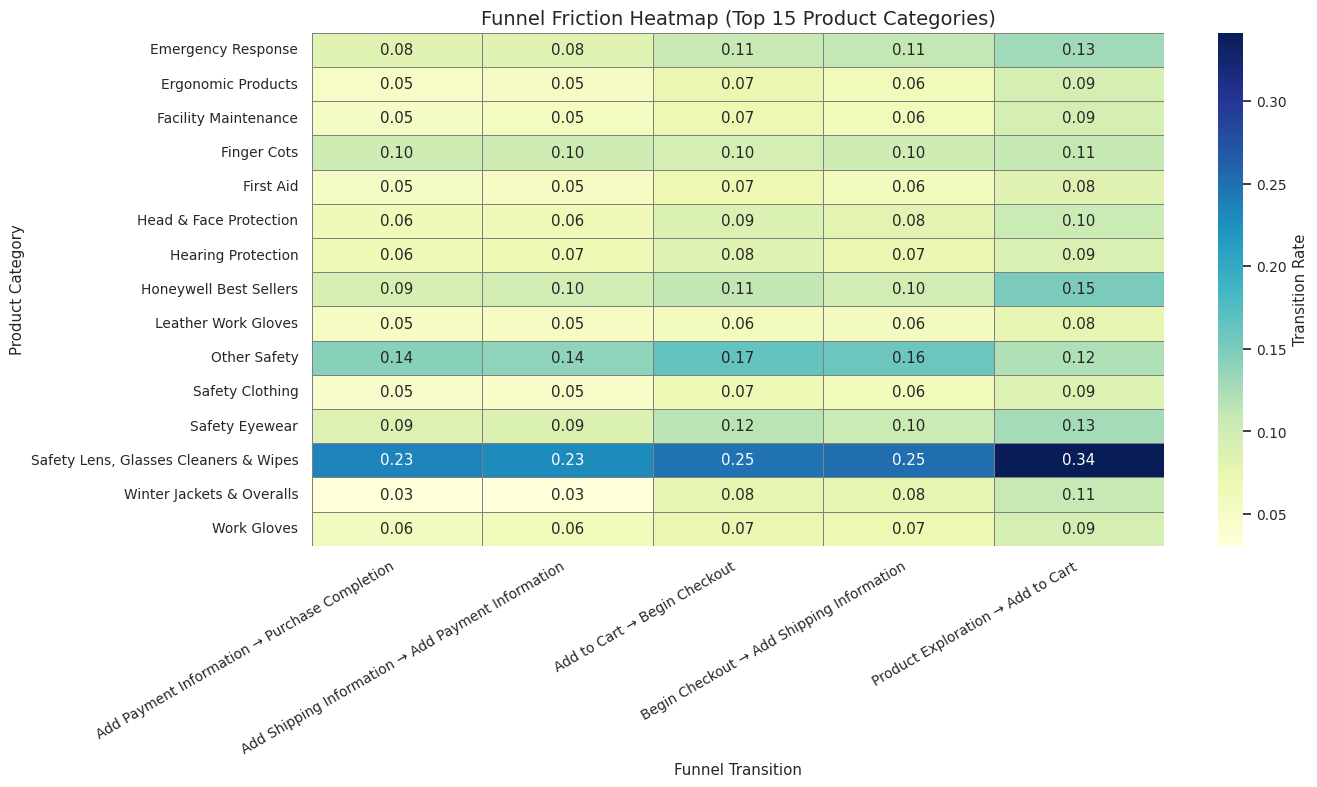

In [ ]:
# First calculate the average transition_rate for each product category
top_categories = transition_df.groupby("product_category_cleaned")["transition_rate"] \
                              .mean().sort_values(ascending=False).head(15).index

# Filter out data from these categories
filtered_df = transition_df[transition_df["product_category_cleaned"].isin(top_categories)]

# Constructing heat map data
pivot = filtered_df.pivot(
    index="product_category_cleaned",
    columns="transition",
    values="transition_rate"
).fillna(0).astype(float)


plt.figure(figsize=(14, 8))
sns.set(font_scale=0.9)

sns.heatmap(
    pivot,
    cmap="YlGnBu",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Transition Rate"}
)

plt.title("Funnel Friction Heatmap (Top 15 Product Categories)", fontsize=14)
plt.xlabel("Funnel Transition")
plt.ylabel("Product Category")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Create purchase label and filter purchase rows with quantity
df["purchase"] = (df["event_name"] == "purchase").astype(int)
df["quantity"] = df["quantity"].fillna(0)

# Step 2: Calculate conversion labels for each session category
session_level_df = (
    df.groupby(["user_session_id", "product_category_cleaned"])["purchase"]
    .max()
    .reset_index()
    .rename(columns={"purchase": "label"})
)

# Step 3: Calculate the conversion rate for each category (i.e., the average label at the session level)
conversion_by_category = (
    session_level_df.groupby("product_category_cleaned")["label"]
    .mean()
    .reset_index()
    .rename(columns={"label": "conversion_rate"})
)

# Step 4: Calculate the total sales for each category (based on purchase rows)
total_quantity_by_category = (
    df[df["purchase"] == 1]
    .groupby("product_category_cleaned")["quantity"]
    .sum()
    .reset_index()
    .rename(columns={"quantity": "total_quantity"})
)

# Step 5: Merge two tables: Conversion Rate + Sales
category_summary = pd.merge(conversion_by_category, total_quantity_by_category, on="product_category_cleaned", how="left")
category_summary["total_quantity"] = category_summary["total_quantity"].fillna(0)

# Step 6: Sort by top categories
category_summary = category_summary.sort_values(by="conversion_rate", ascending=False)

print(category_summary.head(10))



                  product_category_cleaned  conversion_rate  total_quantity
147  Safety Lens, Glasses Cleaners & Wipes         0.280807            5818
129                           Other Safety         0.154696             483
140                         Safety Eyewear         0.125545          434306
63                             Finger Cots         0.111748             264
82                      Hearing Protection         0.100806           32987
48                      Emergency Response         0.095590           10636
90                  Honeywell Best Sellers         0.092486             142
187                            Work Gloves         0.086757         1663162
80                  Head & Face Protection         0.078915           61551
65                               First Aid         0.073559           11407


In [ ]:
import plotly.express as px

# Construct an interactive bubble chart
fig = px.scatter(
    category_summary,
    x="conversion_rate",
    y="total_quantity",
    size="total_quantity",
    color="conversion_rate",
    hover_name="product_category_cleaned",
    hover_data={
        "conversion_rate": ':.2%',
        "total_quantity": True
    },
    title="Product Category Analysis: Conversion Rate vs Sales Volume",
    color_continuous_scale="Plasma",
    size_max=60
)

# Set axis title
fig.update_layout(
    xaxis_title="Conversion Rate",
    yaxis_title="Total Quantity Sold",
    template="simple_white",
    xaxis=dict(tickformat=".0%"),
    coloraxis_colorbar=dict(
        title="Conversion Rate",
        tickformat=".0%"
    )
)

fig.show()


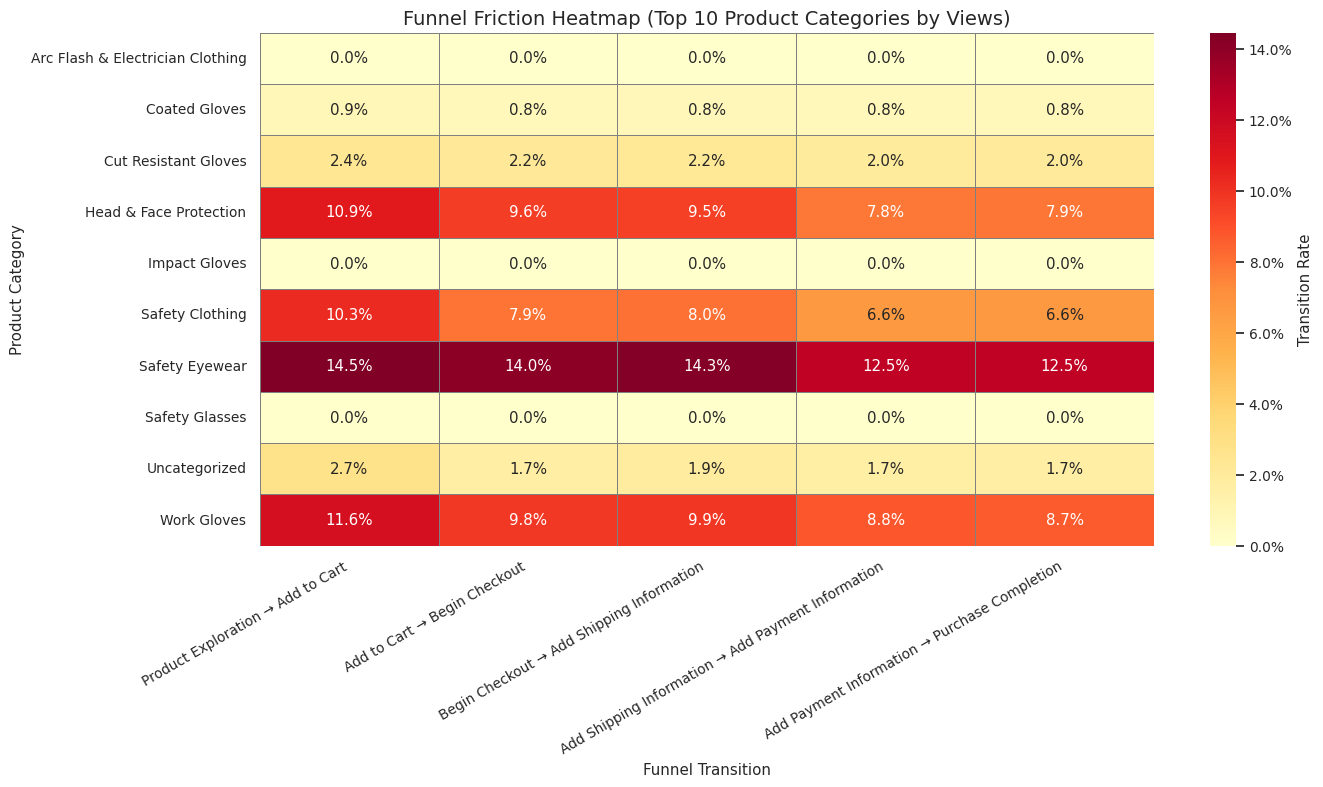

In [ ]:
# 1. Verify that the field exists
required_columns = ['user_session_id', 'product_category_cleaned', 'funnel_stage', 'event_timestamp', 'event_name']
for col in required_columns:
    assert col in df.columns, f"Missing column: {col}"

# 2. Calculate the number of view_item views for each category (for filtering top 10)
category_views = (
    df[df["event_name"] == "view_item"]
    .groupby("product_category_cleaned")["user_session_id"]
    .count()
    .reset_index()
    .rename(columns={"user_session_id": "view_count"})
)

# 3. Get the top 10 categories with the most view_item times
top_10_categories = category_views.sort_values(by="view_count", ascending=False).head(10)["product_category_cleaned"]

# 4. Construct a record of whether each user session, category, and funnel stage appears (filter the top 10)
user_stage = df[
    df["product_category_cleaned"].isin(top_10_categories)
].groupby(['user_session_id', 'product_category_cleaned', 'funnel_stage'])['event_timestamp']\
.min().reset_index()


# 5. Pivot to wide-format
user_stage_pivot = user_stage.pivot_table(
    index=['user_session_id', 'product_category_cleaned'],
    columns='funnel_stage',
    values='event_timestamp',
    aggfunc='count',
    fill_value=0
).reset_index()

# 6. Calculate the pass rate of each transition
transition_data = []

stages = [
    "Product Exploration", "Add to Cart", "Begin Checkout",
    "Add Shipping Information", "Add Payment Information", "Purchase Completion"
]

for i in range(len(stages) - 1):
    stage_from = stages[i]
    stage_to = stages[i + 1]

    temp = user_stage_pivot.copy()
    temp['from_to'] = stage_from + " → " + stage_to
    temp['passed'] = (temp[stage_from] > 0) & (temp[stage_to] > 0)
    temp['base'] = (temp[stage_from] > 0)

    rate_df = temp.groupby('product_category_cleaned').agg(
        transition_rate=('passed', 'mean'),
        base_users=('base', 'sum')
    ).reset_index()

    rate_df['transition'] = stage_from + " → " + stage_to
    transition_data.append(rate_df)

# 7. Merge results
transition_df = pd.concat(transition_data)

# 8. Filter the top 10 categories by sales volume
filtered_df = transition_df[transition_df["product_category_cleaned"].isin(top_10_categories)]

# 9. Convert to the pivot format required by heatmap
pivot = filtered_df.pivot(
    index="product_category_cleaned",
    columns="transition",
    values="transition_rate"
).fillna(0).astype(float)

# 10. Sorting phase
transition_order = [
    "Product Exploration → Add to Cart",
    "Add to Cart → Begin Checkout",
    "Begin Checkout → Add Shipping Information",
    "Add Shipping Information → Add Payment Information",
    "Add Payment Information → Purchase Completion"
]
pivot = pivot[transition_order]

# 11. Drawing
plt.figure(figsize=(14, 8))
sns.set(font_scale=0.9)

ax = sns.heatmap(
    pivot,
    cmap="YlOrRd",
    annot=True,
    fmt=".1%",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Transition Rate"}
)

# Let the colorbar show percentages
colorbar = ax.collections[0].colorbar
colorbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title("Funnel Friction Heatmap (Top 10 Product Categories by Views)", fontsize=14)
plt.xlabel("Funnel Transition")
plt.ylabel("Product Category")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()



## Segment Funnel Drop-off and Abandonment by Product
### preprocessing

In [ ]:
# Keep only the columns you need
df = df[["user_pseudo_id", "funnel_stage", "product_category_cleaned"]].dropna()

# Set the order for the sorting phase (ensure correct order)
stage_order = [
    "Awareness",
    "Product Exploration",
    "Add to Cart",
    "Begin Checkout",
    "Add Shipping Information",
    "Add Payment Information",
    "Purchase Completion"
]
df["funnel_stage"] = pd.Categorical(df["funnel_stage"], categories=stage_order, ordered=True)

### Statistics on the number of users of each product category at each stage

In [ ]:
# Only select the top 5 categories to avoid too complex a graph
top_categories = df["product_category_cleaned"].value_counts().nlargest(5).index.tolist()
df_top = df[df["product_category_cleaned"].isin(top_categories)]

# How many unique users are there for each category of goods at each stage
stage_counts = df_top.groupby(["product_category_cleaned", "funnel_stage"])["user_pseudo_id"].nunique().reset_index()
stage_counts = stage_counts.rename(columns={"user_pseudo_id": "user_count"})

/tmp/ipython-input-12-3158010096.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stage_counts = df_top.groupby(["product_category_cleaned", "funnel_stage"])["user_pseudo_id"].nunique().reset_index()


### Calculate conversion rates between adjacent stages (for drop-off analysis)

In [ ]:
# Convert to wide format
pivot = stage_counts.pivot(index="product_category_cleaned", columns="funnel_stage", values="user_count").fillna(0)

# Calculate the conversion rate of each category in adjacent stages
for i in range(1, len(stage_order)):
    prev_stage = stage_order[i - 1]
    curr_stage = stage_order[i]
    pivot[f"{prev_stage} ➜ {curr_stage}"] = round(pivot[curr_stage] / pivot[prev_stage] * 100, 2)

# Only keep the conversion rate column for viewing
conversion_cols = [col for col in pivot.columns if "➜" in col]
conversion_rates = pivot[conversion_cols]
print(conversion_rates)

funnel_stage                     Awareness ➜ Product Exploration  \
product_category_cleaned                                           
Coated Gloves                                                inf   
Cut Resistant Gloves                                         inf   
Heat & Flame Resistant Clothing                              inf   
Impact Gloves                                                inf   
Work Gloves                                                  inf   

funnel_stage                     Product Exploration ➜ Add to Cart  \
product_category_cleaned                                             
Coated Gloves                                                 6.57   
Cut Resistant Gloves                                         10.35   
Heat & Flame Resistant Clothing                               7.42   
Impact Gloves                                                 5.13   
Work Gloves                                                   2.18   

funnel_stage                    

### Visualizing the Conversion Path (Stacked Funnel Chart)

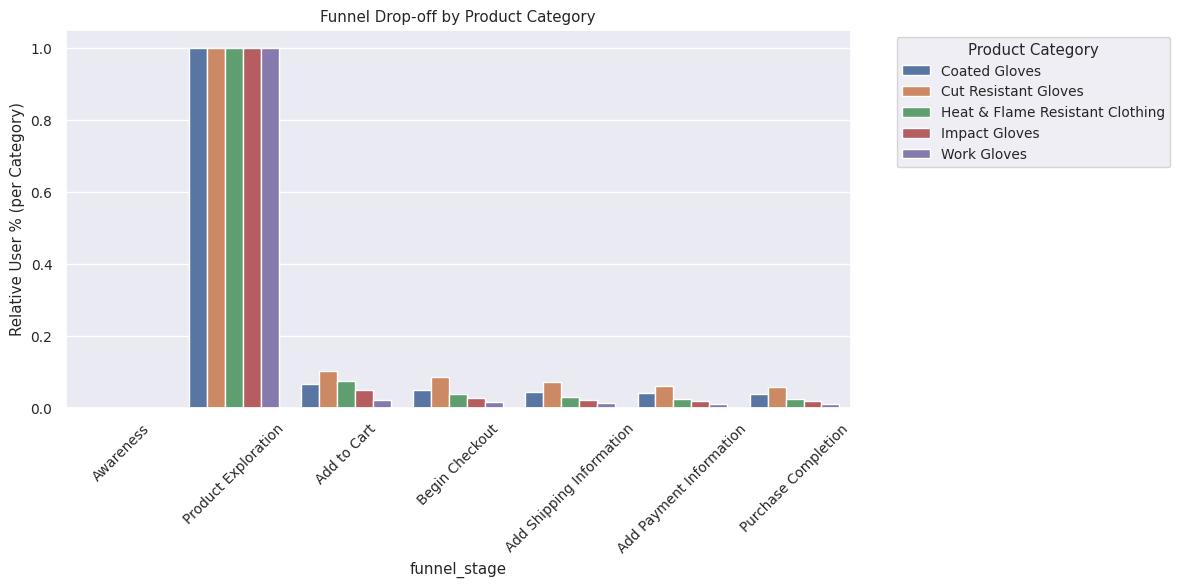

In [ ]:
# Return to long format for easier drawing
stage_counts["percent"] = stage_counts.groupby("product_category_cleaned")["user_count"].transform(lambda x: x / x.max())

plt.figure(figsize=(12, 6))
sns.barplot(
    data=stage_counts,
    x="funnel_stage", y="percent",
    hue="product_category_cleaned"
)
plt.title("Funnel Drop-off by Product Category")
plt.ylabel("Relative User % (per Category)")
plt.xticks(rotation=45)
plt.legend(title="Product Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Micro-Funnel Models: Train classification models per product category to identify high-drop-off product features

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd

# Set the Google Cloud project ID
project_id = "sublime-shift-464703-a2"
client = bigquery.Client(project=project_id)

# SQL query to load the BigQuery table
query = """
SELECT *
FROM `sublime-shift-464703-a2.funnel_output.funnel_output`
"""

# Run the query and convert the result to a DataFrame
df = client.query(query).to_dataframe()

In [ ]:
def train_model_for_category(df_cat, features, target="label"):
    # Skip if the category has too few samples or lacks both classes
    if df_cat[target].nunique() < 2 or len(df_cat) < 50:
        return None

    # Encode categorical variables
    df_cat = df_cat.copy()
    le_dict = {}
    for col in features:
        le = LabelEncoder()
        df_cat[col] = le.fit_transform(df_cat[col].astype(str))
        le_dict[col] = le

    # Define features and target
    X = df_cat[features]
    y = df_cat[target]

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the Random Forest model
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred = clf.predict(X_test)

    # Return evaluation metrics
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred, zero_division=0),
        "n_samples": len(df_cat)
    }

In [ ]:
results = []
features = ["funnel_stage", "item_brand", "price_band"]

for category in df["product_category_cleaned"].unique():
    df_cat = df[df["product_category_cleaned"] == category]
    result = train_model_for_category(df_cat, features)

    if result:
        result["category"] = category
        results.append(result)

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="f1_score", ascending=False)


/tmp/ipython-input-25-912977754.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="f1_score", y="category", palette="viridis")


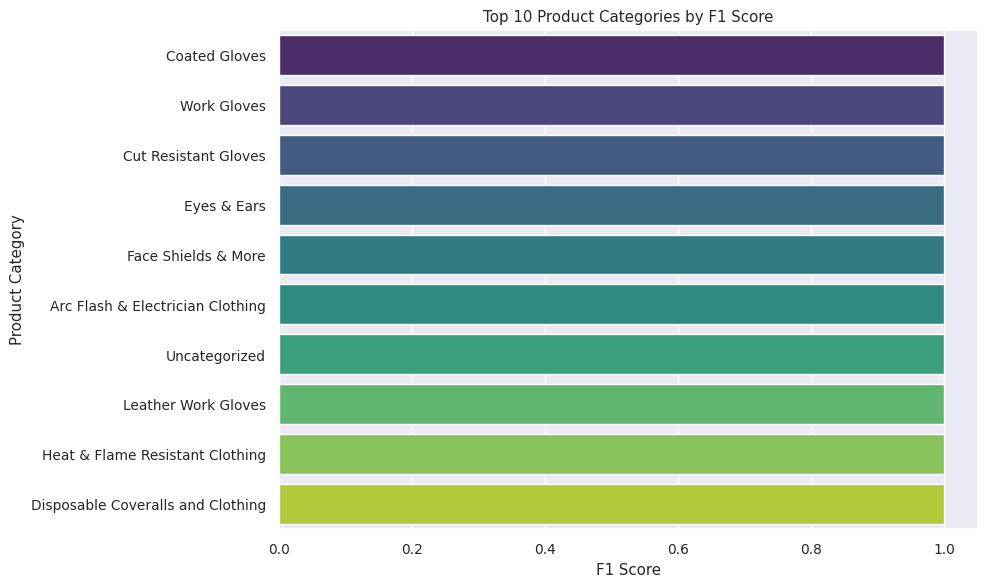

In [ ]:
plt.figure(figsize=(10, 6))
top10 = results_df.head(10)
sns.barplot(data=top10, x="f1_score", y="category", palette="viridis")
plt.title("Top 10 Product Categories by F1 Score")
plt.xlabel("F1 Score")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

In [ ]:
# Check the number of unique product categories
num_categories = df['product_category_cleaned'].nunique()
print(f"Total number of product categories: {num_categories}")

# Display the sample count for each product category (sorted by count in descending order)
category_counts = df['product_category_cleaned'].value_counts()
print("Sample count per product category:")
print(category_counts)

Total number of product categories: 227
Sample count per product category:
product_category_cleaned
Cut Resistant Gloves               989528
Heat & Flame Resistant Clothing    506499
Work Gloves                        479381
Impact Gloves                      375457
Coated Gloves                      366874
                                    ...  
Hazmat Clothing                         2
Wrist Support                           2
CPR Kits & Accessories                  2
IPP - Glass Industry PPE                1
Stretchers                              1
Name: count, Length: 227, dtype: int64


## Micro-Funnel Model (Using Work Gloves as an example)

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     95574
         1.0       1.00      1.00      1.00       303

    accuracy                           1.00     95877
   macro avg       1.00      1.00      1.00     95877
weighted avg       1.00      1.00      1.00     95877

Confusion Matrix:
 [[95574     0]
 [    0   303]]


/tmp/ipython-input-28-2174377273.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances, x='importance', y='feature', palette='Blues_r')


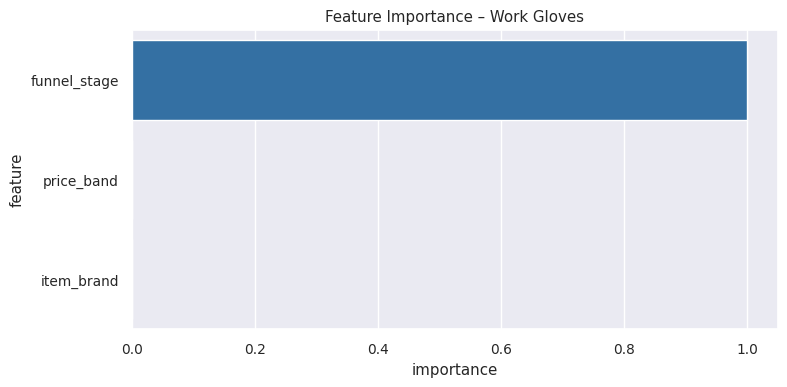

In [ ]:
# 1. Filter a category: Work Gloves
df_glove = df[df['product_category_cleaned'] == 'Work Gloves'].copy()

# 2. Prepare features and target
features = ['funnel_stage', 'item_brand', 'price_band']
target = 'label'

# Encode categorical variables
le_dict = {}
for col in features:
    le = LabelEncoder()
    df_glove[col] = le.fit_transform(df_glove[col].astype(str))
    le_dict[col] = le  # Store encoders for future decoding or interpretation

# 3. Define X (features) and y (target)
X = df_glove[features]
y = df_glove[target]

# 4. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train the Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 7. Visualize feature importance
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': clf.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(data=feature_importances, x='importance', y='feature', palette='Blues_r')
plt.title("Feature Importance – Work Gloves")
plt.tight_layout()
plt.show()